In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_cycle
from neurodsp.utils import create_times
from neurodsp.filt import filter_signal
from neurodsp.timefrequency import amp_by_time, phase_by_time
from neurodsp.plts import plot_time_series, plot_instantaneous_measure

# Cycle-by-cycle philosophy

Neural signals, like the example shown below, are analyzed in order to extract information about
brain activity. We process these signals in order to extract features that will hopefully
correlate with a behavior, pathology, or something else.

Oscillations are sometimes a prominent feature of these signals. In the spectral domain, analyses
characterize these rhythms in terms of their frequency, power, and phase.

The conventional approach to analyzing these properties as a function of time is to study a
narrowband signal by applying a wavelet transform or bandpass filtering followed by the Hilbert
transform. The latter is demonstrated below.

## Conventional Analysis 

Hilbert Transform: Amplitude & Phase

In [2]:
# Simulation settings
np.random.seed(0)
n_seconds = 5
fs = 1000

# Simulate a dynamic periodic signal
sig_periodic = np.zeros(int(n_seconds * fs))

rdsyms = np.linspace(.1, .9, 50)

for ind in range(len(rdsyms)):

    cyc = sim_cycle(.1, fs, 'asine', rdsym=rdsyms[ind])
    
    sig_periodic[ind*100:(ind*100)+100] = cyc

# Mask signal to make bursty
burst_inds = [(500, 1500), (2500, 3000), (3500, 4500)]

sig_periodic[:500] = 0
sig_periodic[1500:2500] = 0
sig_periodic[3000:3500] = 0
sig_periodic[4500:] = 0

# Simulate aperiodic component
sig_aperiodic = sim_powerlaw(n_seconds, fs, f_range=(2, None), exponent=-2, mean=0, variance=.2)

# Combine signals
sig = sig_periodic + sig_aperiodic


/usr/local/anaconda3/envs/voytek/lib/python3.9/site-packages/neurodsp/spectral/utils.py:168: RuntimeWarning: invalid value encountered in reciprocal
  mask = (np.abs(freqs) / f_rotation)**-delta_exponent


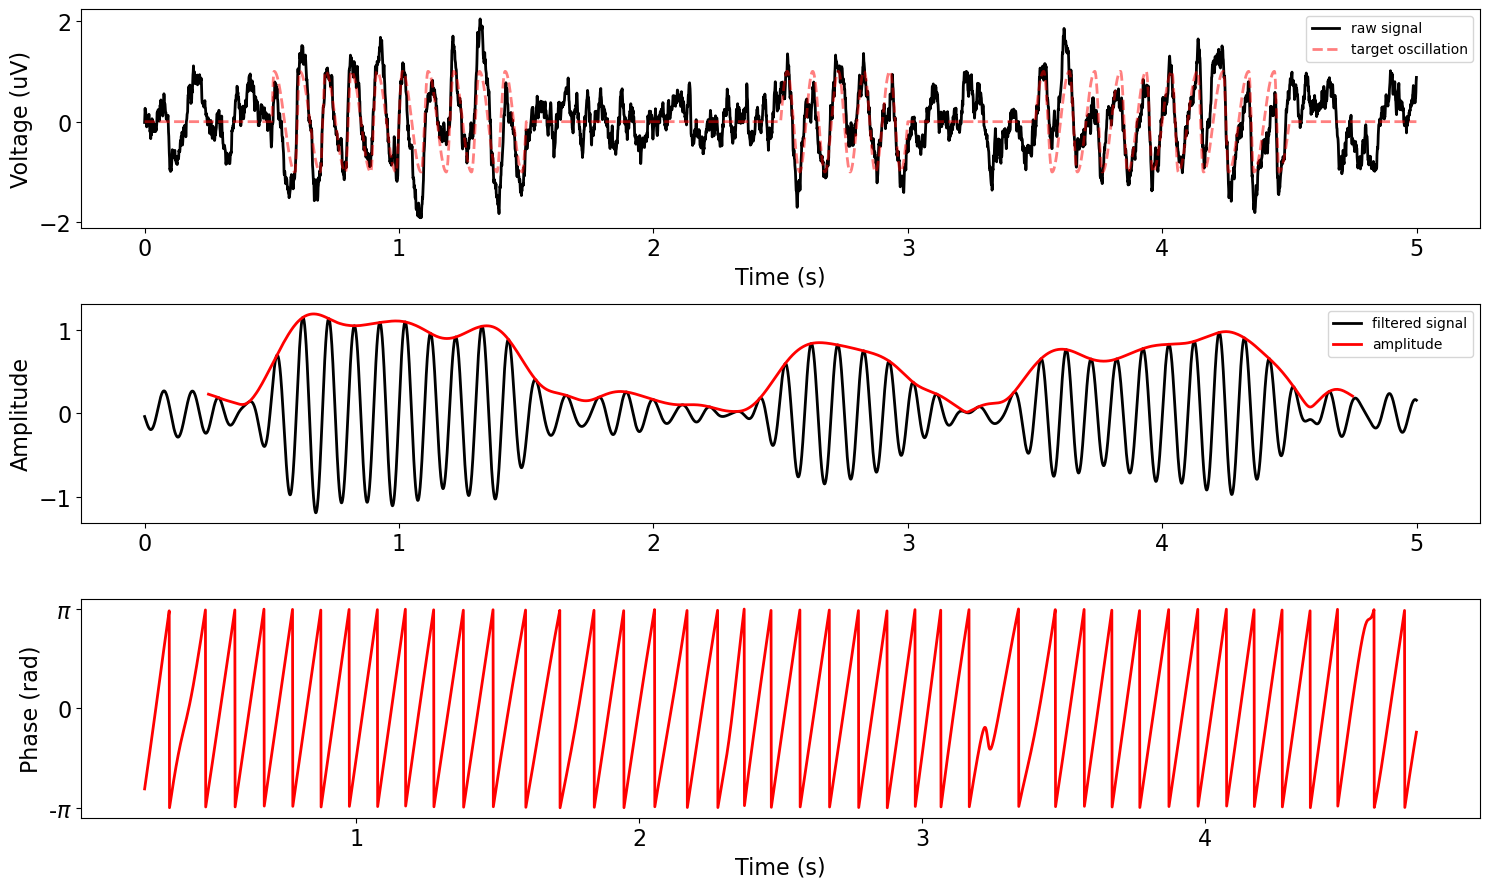

In [3]:
# Filter settings
f_alpha = (8, 12)
n_seconds_filter = .5

# Compute amplitude and phase
sig_filt = filter_signal(sig, fs, 'bandpass', f_alpha, n_seconds=n_seconds_filter, remove_edges=False)
theta_amp = amp_by_time(sig, fs, f_alpha, n_seconds=n_seconds_filter)
theta_phase = phase_by_time(sig, fs, f_alpha, n_seconds=n_seconds_filter)

# Plot signal
fig, axes = plt.subplots(figsize=(15, 9), nrows=3)

# Plot the raw signal
times = create_times(n_seconds, fs)

plot_time_series(times, sig, ax=axes[0], ylabel='Voltage (mV)',
                 xlabel='', lw=2, labels='raw signal')

plot_time_series(times, sig_periodic, ax=axes[0], alpha=.5, ls='--',
                 colors='r', lw=2, labels='target oscillation')

# Plot the filtered signal and oscillation amplitude
plot_instantaneous_measure(times, [sig_filt, theta_amp],
                           ax=axes[1], measure='amplitude', lw=2, xlabel='',
                           labels=['filtered signal', 'amplitude'])

# Plot the phase
plot_instantaneous_measure(times, theta_phase, ax=axes[2], colors='r',
                           measure='phase', lw=2, xlabel='Time (s)')

# Add legends
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right');

This conventional analysis has some advantages and disadvantages. As for advantages:

- Quick calculation
- Neat mathematical theory
- Results largely make sense
- Defined at every point in time

Because of this last property, these traces have come to be known as "instantaneous" amplitude and
phase. And they seem to make a lot of sense, when looking at the raw signal.

However, there are some key disadvantages to this analysis that stem from its sine wave basis:

1. Although defined at all samples, amplitude and phase estimates are not interpretable or meaningful in the absence
of oscillations. When non-oscillatory, amplitude and phase are influenced by the other aspects of the signal, such
as random aperiodic fluctuations. This highlights the importance of burst detection. One conventional burst detection
method uses instantaneous amplitude thresholds. Bycycle adds another approach and determines bursts based on how
consistent shape features are across time.

2. This analysis does not capture a potentially important aspect of the data, in that the oscillatory cycles tend to
have short rises and longer decays. This is partly because the signal is filtered in a narrow frequency band (using a
sine wave basis) that cannot accurately reconstruct nonsinusoidal waveforms. Furthermore, this nonsinusoidal feature
will unintuitively bias amplitude and phase estimates (though perhaps negligibly). Furthermore, there are no apparent
tools for extracting nonsinusoidal properties using conventional techniques.

Below demonstrates how the choice of filter length and frequency range affects the instantaneous amplitude, and how these parameters may lead to different burst definitions.

/usr/local/anaconda3/envs/voytek/lib/python3.9/site-packages/neurodsp/filt/checks.py:162: UserWarning: The low or high frequency stopband never gets attenuated bymore than 20 dB. Increase filter length.
  warn('The low or high frequency stopband never gets attenuated by'\


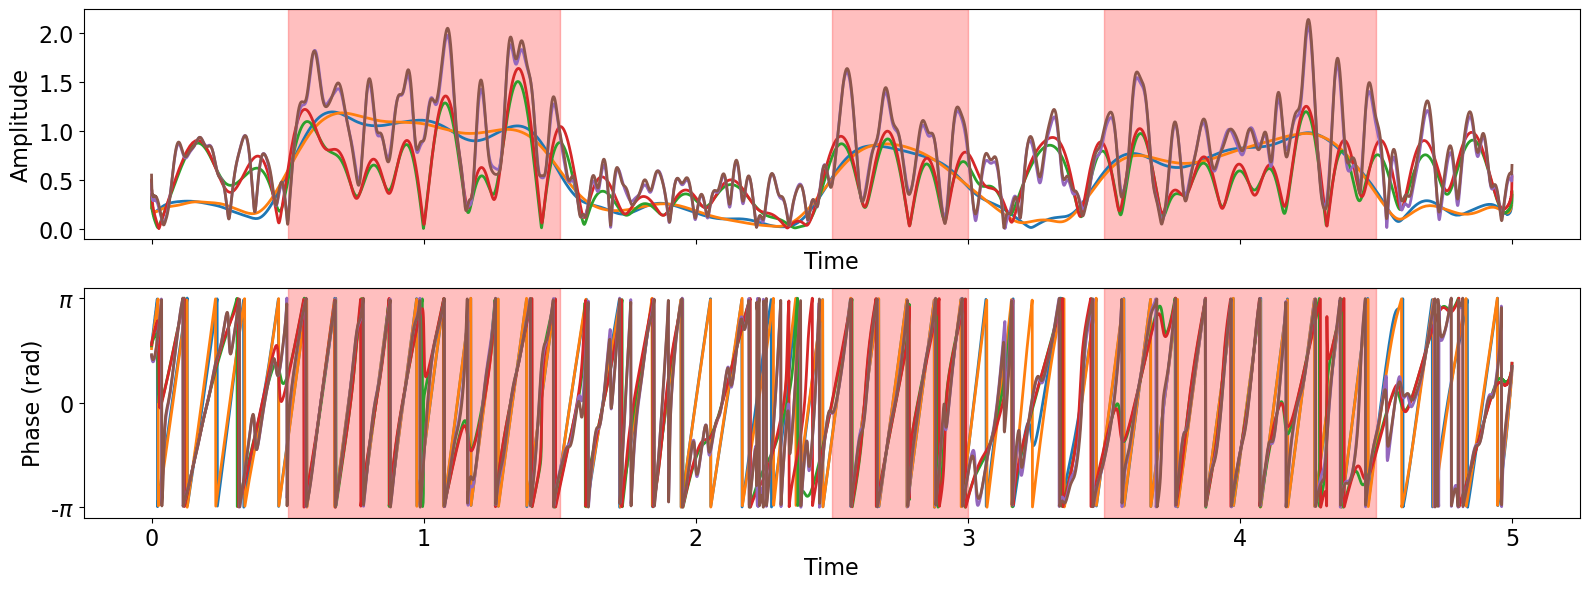

In [4]:
# Different hyperparameter choices - filter length and bandwidth
f_alphas = [(8, 12), (1, 10), (1, 30)]
n_seconds = [.5, 1]

amps = []
phases = []

for f_alpha in f_alphas:
    for n_second_filter in n_seconds:
        amp = amp_by_time(sig, fs, f_alpha, n_seconds=n_second_filter, remove_edges=False)
        amps.append(amp)

        pha = phase_by_time(sig, fs, f_alpha, n_seconds=n_second_filter, remove_edges=False)
        phases.append(pha)

# Plot
fig, axes = plt.subplots(figsize=(16, 6), nrows=2, sharex=True)

plot_instantaneous_measure(times, amps, ax=axes[0], measure='amplitude', lw=2, xlabel='Time')
plot_instantaneous_measure(times, phases, ax=axes[1], measure='phase', lw=2, xlabel='Time')

# Shade true bursts
for burst in burst_inds:
    axes[0].axvspan(times[burst[0]], times[burst[1]], alpha=0.25, color='red')
    axes[1].axvspan(times[burst[0]], times[burst[1]], alpha=0.25, color='red')

Below demonstrates how a narrowband filtered signal, which instantaneous amplitude and phase are computed from, results in a loss on non-sinusoidal features.

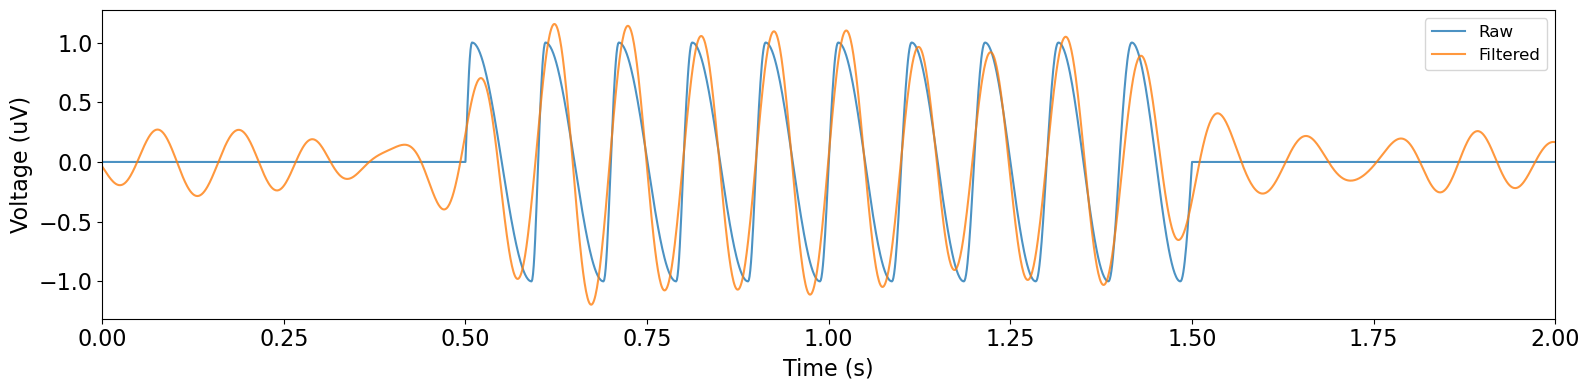

In [5]:
fig, ax = plt.subplots(figsize=(16, 4))

plot_time_series(times, sig_periodic, ax=ax, alpha=.8, colors='C0', xlim=(0, 2), labels='Raw')
plot_time_series(times, sig_filt, ax=ax, colors='C1', alpha=.8, xlim=(0, 2), labels='Filtered')